## Outline

1. Background
    1. Current status
1. Algorithm 1
    1. Organize dataset
    1. Split into hour sections
    1. Split each section into X minute chunks
    1. Iterate over chunks, find `perc_rel_unique` or `perc_abs_unique`
1. Results
    1. Top 5 moments
    1. Graphs
    1. BUGS
1. Big Data EDA

# Background

__Description__:

1. Find the best moments in clips based on where the most users participated. Most is defined as the *ratio of unique users* during a 2 min section to unique users for the entire session.

__Datasets used__:

1. Big data `big_df`: 2409 rows representing one 7 hour 37 minute, 0 second twitch stream chat of [Hearthstone by LiiHS](https://www.twitch.tv/videos/955629991)
    * Used to create all algorithms

## Current status

__Finished:__
1. Algorithm 1
2. Graphing of results

__To do:__
1. ~~Clean up helper functions to be more general~~
1. Double and triple check the algorithm. Currently they don't look accurate

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import datetime as dt
import json

# Helper Functions

NOTE: these were saved into `data_handler.py` helper library

## Organize dataset

In [3]:
def organize_twitch_chat(data):
    # all vars were loaded as str. Change type to datetime/int/bool
    data['created_at'] = pd.to_datetime(data['created_at'])
    data['updated_at'] = pd.to_datetime(data['updated_at'])
    
    df = data[['created_at','updated_at','commenter','message']]
    
    messages = df['message'].apply(pd.Series).drop(['fragments','user_color','user_notice_params'],axis=1)
    users = df['commenter'].apply(pd.Series)
    
    df = df.drop(['message','commenter'], axis=1) # duplicate info
    df = pd.concat([df,users,messages],axis=1)
    df = df.iloc[:,[0,1,2,3,4,5,6,9,10,11,12,13]] # select cols that arent duplicates
    
    return df

## Split into hour sections

In [4]:
class dfSplitter():
    def __init__(self, dataframe):
        '''
        Splits dataframe into multiple dataframes, each 1 hour long

        output:
        ------
        my_list: list
            List of dataframes
        '''
        # init function finds the first split
        dataframe = dataframe.sort_values("created_at")
        first = dataframe[dataframe['created_at'] <= dataframe.loc[0,'created_at'] + pd.Timedelta(hours = 1)]
        self.last_i = first.index.max()
        self.dataframe = dataframe
        self.result = [] # list to append starting timestamp + datasets to
        self.result.append(dataframe.iloc[0, 0]) # NOTE: assumes first col is always "created_at" col
        self.result.append(first)
        
    def find_rest(self):
        '''
        Uses last index of first split to find the others
        '''
        dataframe = self.dataframe
        last_i = self.last_i
        if last_i+1 != len(dataframe):
            new_df = dataframe.loc[last_i+1:,:] # clip df to start at last_i
            newest = new_df[new_df['created_at'] <= new_df.loc[last_i+1,'created_at'] + pd.Timedelta(hours=1)] # filter by hour
            self.result.append(newest) # store in list
            self.last_i = newest.index.max()
            
            self.find_rest() # repeat
        else:
            return dataframe # never actually used

## Split each section into X minute chunks

In [5]:
class xminChats():
    def __init__(self,dataframe, big_unique, min_= 2):
        '''
        Finds the percent unique chatters that chatted every min_ minutes
        
        input
        -----
        dataframe: pd.DataFrame
            Twitch chat dataframe organized and split by dfSplitter
        big_unique: int
            Total number of unique chatters for the entire Twitch stream
        min_: int
            Minute range to find timestamps for. Ex: Find 2 min long timestamps.
        '''
        
        # init function finds the first split
        dataframe = dataframe.sort_values("created_at")
        first = dataframe[dataframe['created_at'] <= dataframe.iloc[0,0] + pd.Timedelta(minutes = min_)]
        
        self.min_ = min_
        self.total_uniques = len(dataframe['_id'].unique())
        self.big_unique = big_unique
        
        self.last_i = first.index.max()
        self.dataframe = dataframe
        
        self.result = []
        self.result.append(first)
        
    def find_rest(self):
        '''
        Uses last index of first split to find the others
        '''
        dataframe = self.dataframe
        last_i = self.last_i
        if last_i+1 < dataframe.index.max(): # NOT len(dataframe), that bugs out and i dont wanna explain why
            new_df = dataframe.loc[last_i+1:,:] # clip df to start new min_ min calc at last_i+1
            newest = new_df[new_df['created_at'] <= new_df.loc[last_i+1,'created_at'] + pd.Timedelta(value=self.min_, unit='minutes')] # filter by minute
            self.result.append(newest) # store in list
            
            self.last_i = newest.index.max()
            self.find_rest() # repeat
        else:
            x=''
    


## Format results as json

In [6]:
def results_jsonified(results, first_sec, results_col):
    '''
    Converts timestamps to seconds, extracts results and makes the whole thing machine readable
    
    input
    -----
    results: pd.DataFrame
        DataFrame with at least the start (datetime) and end (datetime) columns, and a column to sort by.
    first_sec: datetime
        The very first timestamp in the entire twitch chat log. Used to calculate elapsed time in seconds.        
    results_col: str
        Column to sort values by (ascending=False)
        
    output
    ------
    json_results: list
        List of dictionaries with startTime and endTime keys, sorted by best results at top
    '''
    results['first_sec'] = first_sec # to calculate elapsed time from first sec, in seconds
    results = results.sort_values(results_col, ascending=False) # so json format is returned with top result being the most relevant
    json_results = []
    for i, row in results.iterrows():
        og = row['first_sec']
        start = row['start']
        end = row['end']
        
        start_sec = dt.timedelta.total_seconds(start-og) # find difference between first sec and given timestamp, convert that to seconds
        end_sec = dt.timedelta.total_seconds(end-og)
        
        dict_ = {"startTime":start_sec,
                 "endTime":end_sec}
        json_results.append(dict_)
        
    return json_results

## Save as json

NOTE: saved into `data_handler.py` helper library

In [7]:
def save_json(json_results, name):
    '''
    Saves json_results in txt file.
    '''
    str_  = '['
    for dict_ in json_results:
        str_ += str(dict_) + ', \n '
    str_ += ']'
    
    with open(f"exports/{name}.json",'w') as f:
        f.write(str_)
    print(f"Saved to data/{name}.json")

# Algorithm 1

The following functions are unique to algo1

## Find percent unique chatters

In [8]:
def perc_uniques(chunk_list, min_, total_uniques, big_unique):
    '''
    Finds the percent unique chatters for each dataframe in the list. Dataframes assumed to be split using xminChats.find_rest.
    '''

    perc_unique = {
            f'{min_}min_chunk':[],
            'start':[],
            'end':[],
            'num_unique':[],
            'perc_rel_unique':[],
            'perc_abs_unique':[]
    }


    for i in range(len(chunk_list)):
        # calcuate
        chunk = i
        unique = len(chunk_list[i]['_id'].unique())
        timestamp = [chunk_list[i]['created_at'].min(), chunk_list[i]['created_at'].max()]
        perc_rel = unique/total_uniques # this is the total uniques in THAT DATAFRAME, ie the hourly cut
        perc_abs = unique/big_unique # this is the total uniques in the entire twitch session
        # store
        perc_unique[f'{min_}min_chunk'].append(chunk)
        perc_unique['start'].append(timestamp[0])
        perc_unique['end'].append(timestamp[1])
        perc_unique['num_unique'].append(unique)
        perc_unique['perc_rel_unique'].append(perc_rel)
        perc_unique['perc_abs_unique'].append(perc_abs)

    df_unique = pd.DataFrame(perc_unique)
    df_unique['elapsed'] = df_unique['end'] - df_unique['start']
    return df_unique

## Iterate over sections and chunks

In [11]:
def hour_iterator(big_df, min_=2, sort_by='rel'):
    '''
    Pushes all dfs in a list through the xminChats function, returns a dataframe of results
    
    input
    -----
    big_df: pd.DataFrame
        Df of the entire twitch session. This is the one that was split by dfSplitter class
    min_: int
        How long a timestamp range should be
    sort_by: str
        Whether to sort values by `abs` or `rel` unique chatters.
    '''
    ds = dfSplitter(big_df) # initiate
    ds.find_rest() # split big_df into 1 hour long separate dfs
    hour_list = ds.result # result stored in class var. NOTE: index 0 is always the very first timestamp of big_df
    first_sec = hour_list[0]
    hour_list = hour_list[1:]

    # initiate empty results df
    results = pd.DataFrame(columns=['hour', f'{min_}min_chunk', 'start', 'end', 'num_unique', 'perc_rel_unique', 'perc_abs_unique'])
    max_uniques = len(big_df['_id'].unique()) # the total number of unique chatters for the entire twitch session

    # iterate all sections through the class
    for i in range(len(hour_list)):
        fm = xminChats(hour_list[i], max_uniques, min_=min_)
        _n = fm.find_rest() # _n not needed
        chunk_list = fm.result # get back list of dfs, each 2 minutes long
        
        hr_uniques = perc_uniques(chunk_list, min_, total_uniques=fm.total_uniques, big_unique=fm.big_unique)
        hr_uniques['hour'] = i + 1
        results = results.append(hr_uniques)

    results['elapsed'] = results['end'] - results['start'] # to double check length
    pretty_results = results.reset_index(drop=True) # prettify
    pretty_results = pretty_results.sort_values(f'perc_{sort_by}_unique',ascending=False)
    
    json_results = results_jsonified(results, first_sec, results_col=f'perc_{sort_by}_unique') # ordered by top perc_rel_unique
    
    return pretty_results, json_results

# Results

__Description__: Try to find the best moments in clips based on where the most users participated
1. ~~Isolate chat transcript to 1 hour long sessions~~ DONE `dfSplitter`
1. ~~Find total number of unique users that participated in session~~ DONE
1. ~~Find % of users that participated at any given `2 minute` timestamp~~
1. ~~Isolate `top 3` timestamps per session~~

In [12]:
sort_by = 'rel'

data = json.load(open('data/sample_data.json'))
data = pd.DataFrame.from_records(data)
big_df = organize_twitch_chat(data) # fetch appropriate data
results, json_results = hour_iterator(big_df, min_=3, sort_by=sort_by)

In [13]:
# save_json(json_results, "algo1_results")

Saved to data/algo1_results.json


## Top five moments

In [14]:
# for normal people
results.head()

,hour,3min_chunk,start,end,num_unique,perc_rel_unique,perc_abs_unique,elapsed
56,4,10,2021-03-26 03:54:22.575000+00:00,2021-03-26 03:56:01.568000+00:00,13,0.464286,0.13,0 days 00:01:38.993000
14,1,14,2021-03-26 01:14:34.305000+00:00,2021-03-26 01:17:29.086000+00:00,12,0.363636,0.12,0 days 00:02:54.781000
51,4,5,2021-03-26 03:38:27.450000+00:00,2021-03-26 03:41:22.350000+00:00,10,0.357143,0.10,0 days 00:02:54.900000
53,4,7,2021-03-26 03:44:48.428000+00:00,2021-03-26 03:47:28.280000+00:00,10,0.357143,0.10,0 days 00:02:39.852000
13,1,13,2021-03-26 01:11:32.803000+00:00,2021-03-26 01:14:31.801000+00:00,11,0.333333,0.11,0 days 00:02:58.998000


[Twitch Source](https://www.twitch.tv/videos/955629991)

Variables:
* `hour`: section of twitch chat df, after df was split into 1 hour sections
* `xmin_chunk`: chunk of hour section, after section was split into x min chunks
* `start`: starting timestamp of chunk
* `end`: ending timestamp of chunk
* `num_unique`: number of unique chatters in that chunk
* `perc_rel_unique`: percent of unique __hour section__ chatters participating in that chunk
* `perc_abs_unique`: percent of unique __twitch df__ chatters participating in that chunk

__Conclusion__: The max relative chat engagement was around 55% in the eighth hour of twitch chat during chunk_16. Timestamps `03-20 05:32` to `03-20 05:33` are good candidates

In [15]:
# for engineers
json_results[:8]

[{'startTime': 12827.018, 'endTime': 12926.011},
 {'startTime': 3238.748, 'endTime': 3413.529},
 {'startTime': 11871.893, 'endTime': 12046.793},
 {'startTime': 12252.871, 'endTime': 12412.723},
 {'startTime': 3057.246, 'endTime': 3236.244},
 {'startTime': 8247.804, 'endTime': 8397.54},
 {'startTime': 11677.897, 'endTime': 11830.317},
 {'startTime': 3602.37, 'endTime': 3781.322}]

## Graphs

/home/jupyter-pomkos/.conda/envs/mess_env/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 1.05, 'Percent chatters, relative to each hour')

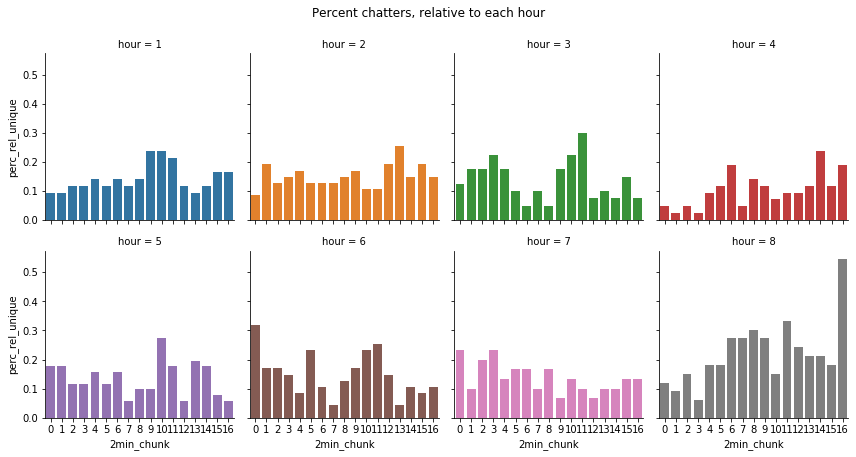

In [98]:
g = sns.FacetGrid(results,col='hour', col_wrap = 4, hue = 'hour')
g.map(sns.barplot,'2min_chunk','perc_rel_unique')

plt.suptitle("Percent chatters, relative to each hour",y=1.05)

/home/jupyter-pomkos/.conda/envs/mess_env/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 1.05, 'Percent of total twitch session chatters participating at each chunk')

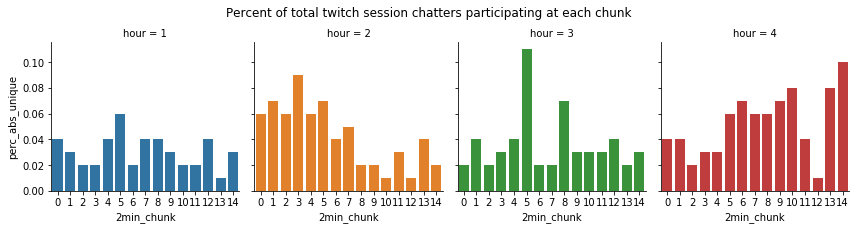

In [87]:
g = sns.FacetGrid(results,col='hour', col_wrap = 4, hue = 'hour')
g.map(sns.barplot,'2min_chunk','perc_abs_unique')

plt.suptitle("Percent of total twitch session chatters participating at each chunk",y=1.05)

## BUGS

Why do the perc_abs_unique and perc_rel_unique have the same exact graphs???

# Big Data EDA

[Twitch Source](https://www.twitch.tv/videos/955629991)

In [3]:
data = json.load(open('data/sample_data.json'))
data = pd.DataFrame.from_records(data)
big_df = organize_twitch_chat(data) # fetch appropriate data

NameError: name 'organize_twitch_chat' is not defined

In [ ]:
sns.histplot(big_df['created_at'], bins=100)
plt.title("Message Count")

In [ ]:
sns.histplot(big_df['display_name'])
plt.title("Messages per User")